In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
# load data

dataX=pd.read_csv("/content/drive/My Drive/traindata/trainX.csv")
dataA=pd.read_csv("/content/drive/My Drive/traindata/trainA.csv")
dataY=pd.read_csv("/content/drive/My Drive/traindata/trainY.csv")

# remove index

dataX=dataX.values[:,1:]
dataY=dataY.values[:,1:-1]
dataA=dataA.values[:,1:]

In [ ]:
np.where(dataA==1)[0]

array([  4,   5,   9,  11,  13,  14,  19,  26,  35,  38,  40,  42,  43,
        44,  45,  49,  51,  53,  54,  61,  63,  64,  67,  69,  72,  73,
        76,  78,  79,  81,  82,  83,  85,  88,  90,  94,  95,  98, 102,
       103, 104, 106, 108, 109, 110, 111, 112, 113, 114, 123, 125, 126,
       128, 130, 133, 135, 139, 141, 143, 146, 147, 150, 159, 162, 167,
       168, 171, 173, 177, 181, 183, 184, 186, 187, 188, 189, 190, 192,
       193, 195, 196, 200, 201, 203, 206, 210, 212, 214, 216, 218, 221,
       223, 226, 227, 230, 233, 238, 240, 243, 244, 254, 255, 260, 263,
       264, 266, 270, 276, 277, 280, 283, 289, 292, 294, 297, 298, 299,
       300, 301, 306, 311, 312, 315, 318, 321, 322, 323, 325, 329, 331,
       332, 333, 336, 338, 343, 346, 348, 350, 352, 354, 357, 358, 359,
       361, 364, 365, 367, 376, 377, 382, 383, 384, 387, 390, 392, 393,
       397, 398, 399, 404, 405, 407, 409, 411, 412, 417, 418, 419, 421,
       429, 433, 434, 439, 441, 448, 449, 450, 451, 457, 459, 46

In [ ]:
dataX.shape

(666, 17)

In [ ]:
# split cure or not cure

data_CX=dataX[np.where(dataA==1)[0]]
dataNCX=dataX[np.where(dataA!=1)[0]]
data_CY=dataY[np.where(dataA==1)]
dataNCY=dataY[np.where(dataA!=1)]

In [ ]:
from sklearn.model_selection import train_test_split

train_data_C,test_data_C,train_targets_C,test_targets_C=train_test_split(data_CX,data_CY)
train_dataNC,test_dataNC,train_targetsNC,test_targetsNC=train_test_split(data_CX,data_CY)


In [ ]:
mean_C = train_data_C.mean(axis=0)
train_data_C -= mean_C
std_C = train_data_C.std(axis=0)
train_data_C /= std_C

test_data_C -= mean_C
test_data_C /= std_C


meanNC = train_dataNC.mean(axis=0)
train_dataNC -= meanNC
stdNC = train_dataNC.std(axis=0)
train_dataNC /= stdNC

test_dataNC -= meanNC
test_dataNC /= stdNC

In [ ]:
from keras import models
from keras import layers

def build_model_C():
    # 동일한 모델을 여러 번 생성할 것이므로 함수를 만들어 사용합니다
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data_C.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mean_absolute_error'])
    return model


def build_modelNC():
    # 동일한 모델을 여러 번 생성할 것이므로 함수를 만들어 사용합니다
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_dataNC.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mean_absolute_error'])
    return model

In [ ]:
# cure

k = 4
num_val_samples = len(train_data_C) // k
num_epochs = 100
all_scores_C = []
for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = train_data_C[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets_C[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data_C[:i * num_val_samples],
         train_data_C[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets_C[:i * num_val_samples],
         train_targets_C[(i + 1) * num_val_samples:]],
        axis=0)

    # 케라스 모델 구성(컴파일 포함)
    model_C = build_model_C()
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않습니다)
    model_C.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # 검증 세트로 모델 평가
    val_mse, val_mae = model_C.evaluate(val_data, val_targets, verbose=0)
    all_scores_C.append(val_mae)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [ ]:
# not cure

k = 4
num_val_samples = len(train_dataNC) // k
num_epochs = 100
all_scoresNC = []
for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = train_dataNC[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targetsNC[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_dataNC[:i * num_val_samples],
         train_dataNC[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targetsNC[:i * num_val_samples],
         train_targetsNC[(i + 1) * num_val_samples:]],
        axis=0)

    # 케라스 모델 구성(컴파일 포함)
    modelNC = build_modelNC()
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않습니다)
    modelNC.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # 검증 세트로 모델 평가
    val_mse, val_mae = modelNC.evaluate(val_data, val_targets, verbose=0)
    all_scoresNC.append(val_mae)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [ ]:
all_scores_C,np.mean(all_scores_C)


([5.693963050842285, 8.507234573364258, 6.448135852813721, 4.044273853302002],
 6.173401832580566)

In [ ]:
all_scoresNC,np.mean(all_scoresNC)


([5.0792236328125, 7.0672149658203125, 5.6479363441467285, 5.166028022766113],
 5.740100741386414)

In [ ]:
from keras import backend as K

# 메모리 해제
K.clear_session()

In [ ]:
# cure

num_epochs = 1000
all_mae_histories_C = []
for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = train_data_C[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets_C[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data_C[:i * num_val_samples],
         train_data_C[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets_C[:i * num_val_samples],
         train_targets_C[(i + 1) * num_val_samples:]],
        axis=0)

    # 케라스 모델 구성(컴파일 포함)
    model_C = build_model_C()
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않습니다)
    history = model_C.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories_C.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [ ]:
# not cure

num_epochs = 1000
all_mae_historiesNC = []
for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = train_dataNC[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targetsNC[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_dataNC[:i * num_val_samples],
         train_dataNC[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targetsNC[:i * num_val_samples],
         train_targetsNC[(i + 1) * num_val_samples:]],
        axis=0)

    # 케라스 모델 구성(컴파일 포함)
    modelNC = build_modelNC()
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않습니다)
    history = modelNC.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_historiesNC.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [ ]:
average_mae_history_C = [
    np.mean([x[i] for x in all_mae_histories_C]) for i in range(num_epochs)]

average_mae_historyNC = [
    np.mean([x[i] for x in all_mae_historiesNC]) for i in range(num_epochs)]

In [ ]:
import matplotlib.pyplot as plt

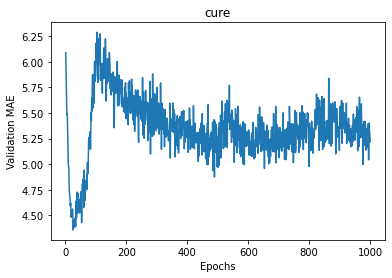

In [ ]:
plt.plot(range(1, len(average_mae_history_C) + 1), average_mae_history_C)
plt.title('cure')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

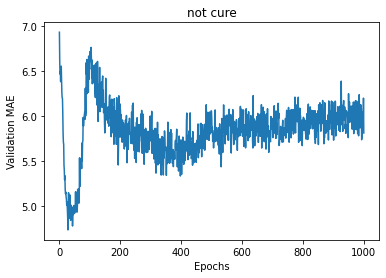

In [ ]:
plt.plot(range(1, len(average_mae_historyNC) + 1), average_mae_historyNC)
plt.title('not cure')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

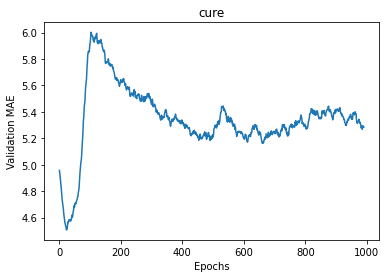

In [ ]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history_C = smooth_curve(average_mae_history_C[10:])

plt.plot(range(1, len(smooth_mae_history_C) + 1), smooth_mae_history_C)
plt.title('cure')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

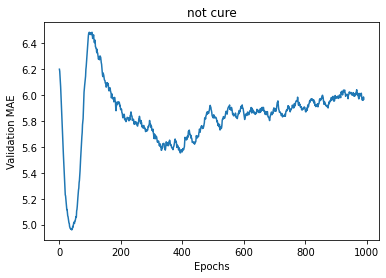

In [ ]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_historyNC = smooth_curve(average_mae_historyNC[10:])

plt.plot(range(1, len(smooth_mae_historyNC) + 1), smooth_mae_historyNC)
plt.title('not cure')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

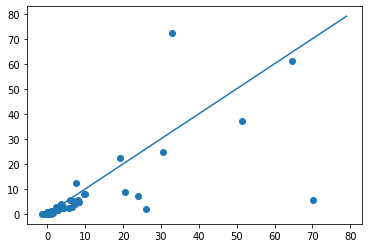

In [ ]:
pred_targets=model_C.predict(test_data_C)

plt.scatter(pred_targets,test_targets_C)
plt.plot(np.arange(80),np.arange(80))

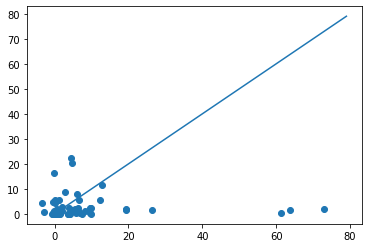

In [ ]:
pred_targets=modelNC.predict(test_data_C)

plt.scatter(pred_targets,test_targetsNC)
plt.plot(np.arange(80),np.arange(80))

In [ ]:
test_data_C.shape

(67, 17)

In [ ]:
train_data_C.shape

(200, 17)

In [ ]:
test__C[0]

array([-1.37759237,  0.4333887 ,  0.19471226, -0.87227772, -0.1026495 ,
       -1.13855155,  1.46550279, -0.49237683,  1.27520976,  1.05903387,
        0.25045933,  0.98894258,  0.74250768,  0.1633769 , -1.0675637 ,
        0.58248632, -0.78707102])

In [ ]:
time_C=model_C.predict(test_data_C)[0]
timeNC=modelNC.predict(test_data_C)[0]

if time_C > timeNC:
  print('치료하세용')
else:
  print('치료하지 마세용')

print(test_targets_C[0],time_C,timeNC,time_C-timeNC)



치료하세용
0.14 [0.33096874] [0.0303096] [0.30065915]


In [ ]:
import lightgbm